# Intent Classification

In [ ]:
! pip install transformers -q

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

import tensorflow as tf
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from transformers import TFBertForSequenceClassification, BertTokenizerFast

from sklearn.preprocessing import LabelEncoder

tf.random.set_seed(42)

## Load Dataset

In [ ]:
!gdown 1OlcvGWReJMuyYQuOZm149vHWwPtlboR6 --output train.csv
!gdown 1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w --output valid.csv
!gdown 1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF --output test.csv

Downloading...
From: https://drive.google.com/uc?id=1OlcvGWReJMuyYQuOZm149vHWwPtlboR6
To: /content/train.csv
100% 799k/799k [00:00<00:00, 7.05MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Oi5cRlTybuIF2Fl5Bfsr-KkqrXrdt77w
To: /content/valid.csv
100% 43.3k/43.3k [00:00<00:00, 97.9MB/s]
Downloading...
From: https://drive.google.com/uc?id=1ep9H6-HvhB4utJRLVcLzieWNUSG3P_uF
To: /content/test.csv
100% 43.1k/43.1k [00:00<00:00, 75.4MB/s]


In [ ]:
train = pd.read_csv("train.csv")
valid = pd.read_csv("valid.csv")
test = pd.read_csv("test.csv")

In [ ]:
train = pd.concat([train, valid])
train.head()

,text,intent
0,listen to westbam alumb allergic on google music,PlayMusic
1,add step to me to the 50 clásicos playlist,AddToPlaylist
2,i give this current textbook a rating value of...,RateBook
3,play the song little robin redbreast,PlayMusic
4,please add iris dement to my playlist this is ...,AddToPlaylist


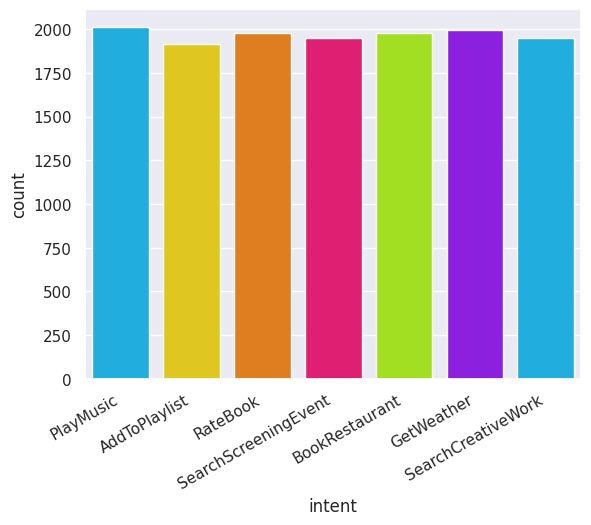

In [ ]:
sns.countplot(x=train.intent, palette=["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"])
plt.xticks(rotation=30, horizontalalignment='right');

## Download BERT Model

In [ ]:
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')
bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=7)

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


## Data Preprocessing

In [ ]:
def tokenize(text):
    return tokenizer(text,
                     add_special_tokens=True,
                     max_length=64,
                     padding='max_length',
                     truncation=True,
                     return_tensors='tf',
                     return_token_type_ids=False)

label_encoder = LabelEncoder()

In [ ]:
train_encodings = tokenize(train['text'].to_list())
train_labels = label_encoder.fit_transform(train['intent'])

train_encodings.input_ids.shape

TensorShape([13784, 64])

## Model Architecture

In [ ]:
input_ids = Input(shape=(64,), name='input_ids', dtype='int32')
attention_mask = Input(shape=(64,), name='attention_mask', dtype='int32')
inputs = {'input_ids': input_ids, 'attention_mask': attention_mask}

bert_outputs = bert_model(inputs)

dense = Dense(256, activation='relu')(bert_outputs['logits'])
outputs = Dense(7, activation='softmax')(dense)

model = Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 attention_mask (InputLayer  [(None, 64)]                 0         []                            
 )                                                                                                
                                                                                                  
 input_ids (InputLayer)      [(None, 64)]                 0         []                            
                                                                                                  
 tf_bert_for_sequence_class  TFSequenceClassifierOutput   1094876   ['attention_mask[0][0]',      
 ification (TFBertForSequen  (loss=None, logits=(None,    23         'input_ids[0][0]']           
 ceClassification)           7),                                                              

## Model Training

In [ ]:
model.compile(optimizer=Adam(learning_rate=1e-04),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

train_encodings = {'input_ids': train_encodings['input_ids'], 'attention_mask': train_encodings['attention_mask']}

history = model.fit(x=train_encodings, y=train_labels, epochs=3, batch_size=64, validation_split=0.1, verbose=2)

Epoch 1/3
194/194 - 210s - loss: 0.4701 - accuracy: 0.9093 - val_loss: 0.0799 - val_accuracy: 0.9833 - 210s/epoch - 1s/step
Epoch 2/3
194/194 - 164s - loss: 0.0890 - accuracy: 0.9809 - val_loss: 0.0774 - val_accuracy: 0.9790 - 164s/epoch - 848ms/step
Epoch 3/3
194/194 - 165s - loss: 0.0562 - accuracy: 0.9869 - val_loss: 0.0586 - val_accuracy: 0.9877 - 165s/epoch - 849ms/step


## Evaluation

In [ ]:
test_encodings = tokenize(test['text'].to_list())
test_labels = label_encoder.transform(test['intent'])

test_encodings.input_ids.shape

TensorShape([700, 64])

In [ ]:
test_encodings = {'input_ids': test_encodings['input_ids'], 'attention_mask': test_encodings['attention_mask']}

eval = model.evaluate(x=test_encodings, y=test_labels, verbose=2, return_dict=True)

22/22 - 3s - loss: 0.1160 - accuracy: 0.9686 - 3s/epoch - 148ms/step


In [ ]:
def plot_metrics(history, eval):
    metrics = ['accuracy', 'loss']
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))

    for i, ax in enumerate(axs.flatten()):
        x = history.epoch

        y_train = history.history[metrics[i]]
        ax.plot(x, y_train, marker='.', label=f'Train: {y_train[-1]:.2f}')

        y_val = history.history['val_' + metrics[i]]
        ax.plot(x, y_val, marker='.', label=f'Validation: {y_val[-1]:.2f}')

        y_test = eval[metrics[i]]
        ax.plot(x[-1], y_test, marker='.', label=f'Test: {y_test:.2f}')

        ax.set_ylim(0, None if metrics[i] == 'loss' else 1)
        ax.set_xticks(x)
        ax.set_xlabel('Epoch')
        ax.set_title(metrics[i].capitalize())
        ax.legend();

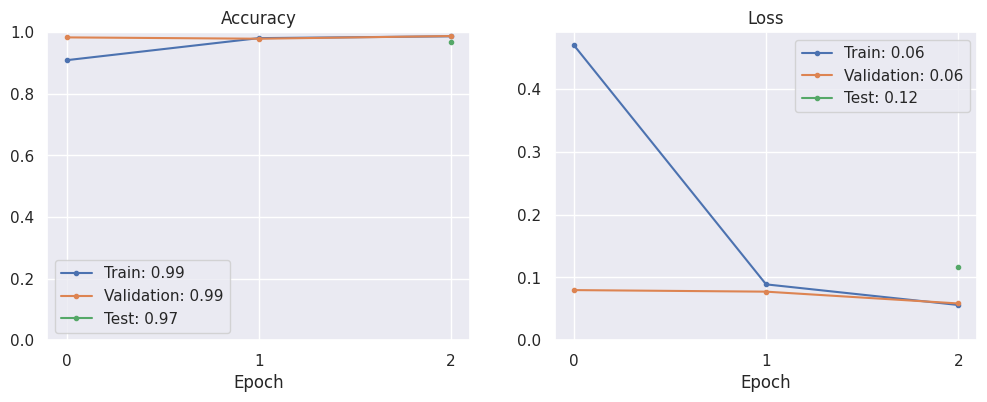

In [ ]:
plot_metrics(history, eval)

## Prediction

In [ ]:
pred_encodings = tokenize("Let's listen to some upbeat music to improve your mood.")
pred_encodings = {'input_ids': pred_encodings['input_ids'], 'attention_mask': pred_encodings['attention_mask']}

pred = model.predict(pred_encodings)
label_encoder.inverse_transform([np.argmax(pred)])

1/1 [==============================] - 3s 3s/step


array(['PlayMusic'], dtype=object)